# synthetic validation


## 1. Real photocurrent, real PSCs

In [1]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import grid_utils as util
import subtract_utils
import circuitmap as cm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
import photocurrent_sim
import jax.random as jrand
import subtractr

In [31]:
# load photocurrent examples
with h5py.File('../visualization/pc_examples_fastdecay.h5', 'r') as f:
    pc_examples = np.array(f['traces'])
key = jrand.PRNGKey(0)

# load datset with no photocurrents
pscs, stim_mat, powers, targets = util.load_h5_data('../data/marta/ai203/preprocessed/201118_cell1_A_cmFormat.mat')

# load subtractr net
subtractr_checkpoint = './grid_artifacts/cunning-brattain-9345/cunning-brattain-9345-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=127-step=360063.ckpt'

net = cm.NeuralDemixer(
    path=subtractr_checkpoint,
    unet_args=dict(
            down_filter_sizes=(16, 32, 64, 128),
            up_filter_sizes=(64, 32, 16, 4),
    ))

# load demixer
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
demixer = cm.NeuralDemixer(
    path=demixer_checkpoint,
)

In [50]:
def make_hybrid_dataset(
    pc_templates,
    key,
    size=100,
    sample_from_templates_kwargs=None,
    sample_psc_kernel_kwargs=None,
    ):

    if sample_from_templates_kwargs is None:
        sample_from_templates_kwargs = dict(
            jitter_ms=0.1,
            window_len=900,
            smoothing_sigma=5,
            max_scaling_frac=0.5,
            msecs_per_sample=0.05,
            stim_start=100,
            exponential_fit_start_idx=450,
            add_target_gp=False,
            target_gp_lengthscale=50,
            target_gp_scale=0.01,
        )

    if sample_psc_kernel_kwargs is None:
        sample_psc_kernel_kwargs = dict(
            amplitude_lower=0.01,
            amplitude_upper=0.1,
            delta_lower=250,
            delta_upper=400,
        )


    photocurrents = photocurrent_sim.sample_from_templates(
        pc_templates,
        key,
        size=size,
        **sample_from_templates_kwargs,
    )

    pscs = cm.neural_waveform_demixing._sample_psc_kernel(
        n_samples=size,
        **sample_psc_kernel_kwargs
    )

    return photocurrents + pscs, photocurrents, pscs




In [55]:
key = jrand.PRNGKey(0)
combined, photocurrents, pscs = make_hybrid_dataset(
    pc_examples,
    key,
    size=10,
)

/Users/Bantin/anaconda3/envs/circuitmap/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Demixing PSC traces... complete (elapsed time 0.03s, device=cpu).


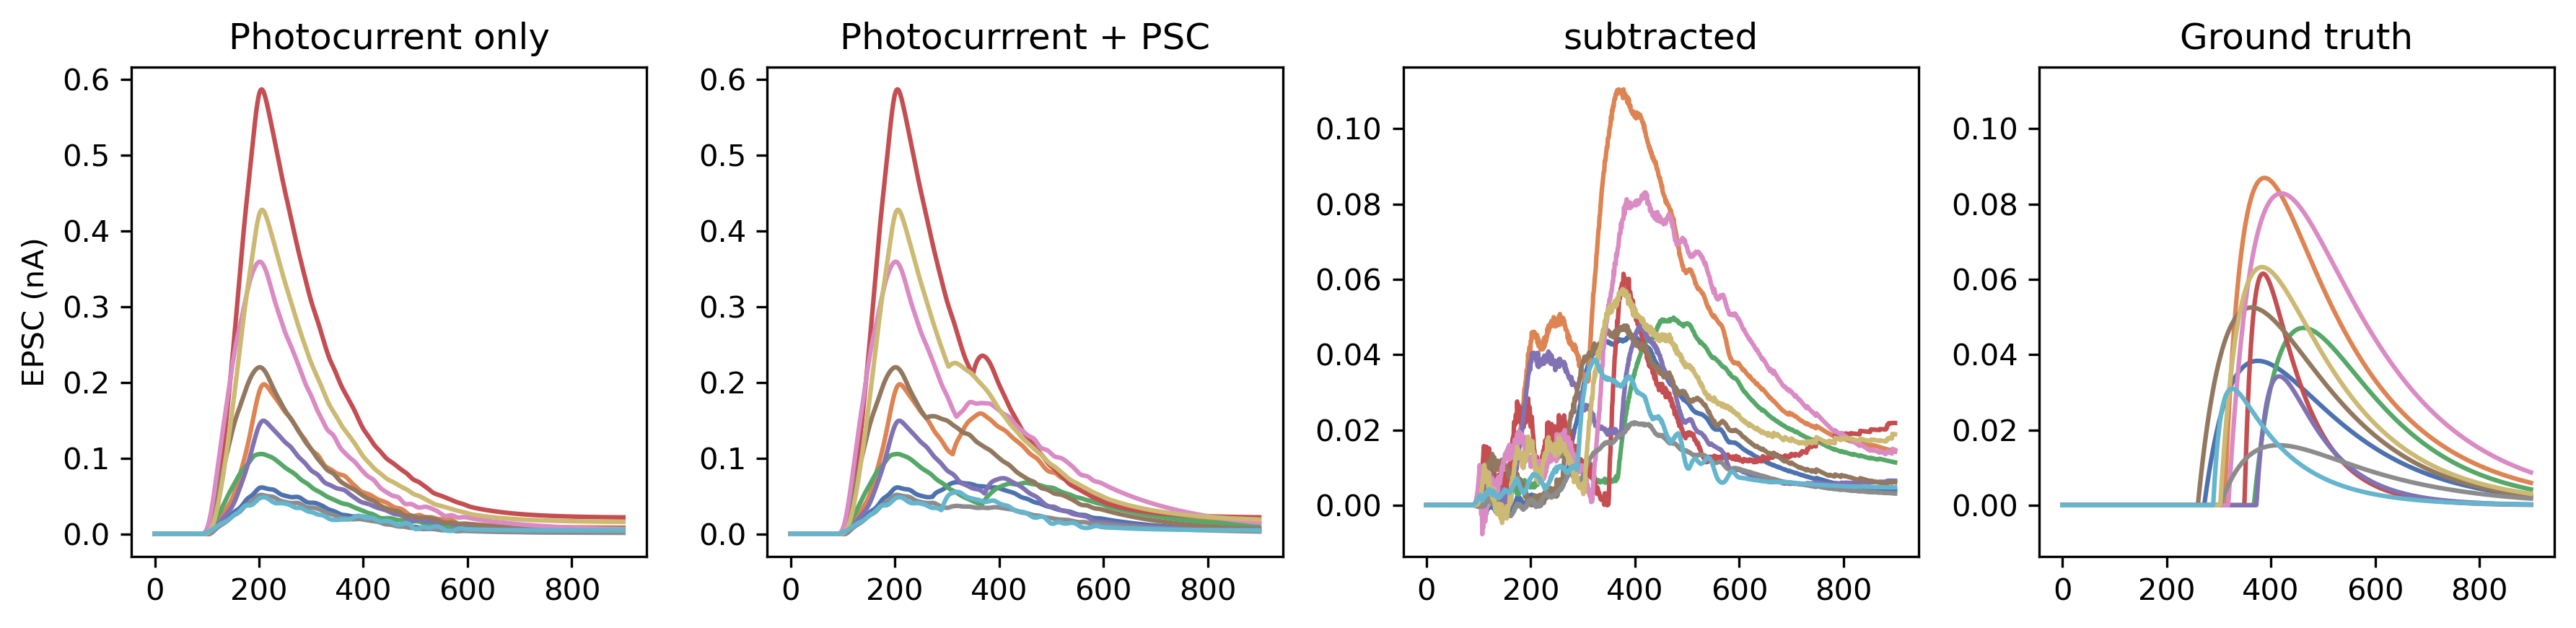

In [57]:
import seaborn as sns
sns.set_palette('deep')

fig,  axs = plt.subplots(1, 4, figsize=(12,3), dpi=300, facecolor='white')

est = net(combined)
subtracted = combined - est

axs[0].plot(photocurrents.T)
axs[1].plot(combined.T)
axs[2].plot(subtracted.T)
axs[3].plot(pscs.T)
axs[3].set_ylim(axs[2].get_ylim())

axs[0].set_title('Photocurrent only')
axs[1].set_title('Photocurrrent + PSC')
axs[2].set_title('subtracted')
axs[3].set_title('Ground truth')
axs[0].set_ylabel('EPSC (nA)')
plt.tight_layout()
plt.show()

## Where during the trial do we tend to make errors?

In [71]:
latencies = np.arange(160, 400, 10)

In [69]:
mses = []
stds = []
for psc_latency in latencies:

    combined, photocurrents, pscs = make_hybrid_dataset(
        pc_examples,
        key,
        size=1000,
        sample_psc_kernel_kwargs=dict(
            delta_lower=psc_latency, delta_upper=psc_latency,
            amplitude_lower=0.01, amplitude_upper=0.2,)
    )

    est = net(combined)
    subtracted = combined - est
    errs = np.square(subtracted - pscs)
    per_trial_err = np.sum(errs, axis=-1)
    mse = np.mean(per_trial_err)
    std = np.std(per_trial_err)

    mses.append(mse)
    stds.append(std)


/Users/Bantin/anaconda3/envs/circuitmap/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Demixing PSC traces... complete (elapsed time 1.79s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.72s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.69s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.71s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.68s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.67s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.77s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.85s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.77s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.75s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.75s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.73s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.72s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.70s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.68s, device=cpu).
Demixing P

<ErrorbarContainer object of 3 artists>

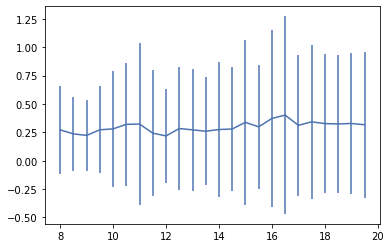

In [72]:
plt.errorbar(latencies * 0.05, mses, stds, None)